In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import gamma, factorial
from scipy.special import loggamma, logsumexp
from scipy.spatial.distance import pdist
sns.set()
from time import time
%matplotlib

Using matplotlib backend: Qt5Agg


In [2]:
#def stirling(x):
   # return (x-0.5)*np.log(x+1)-x+1.9189385332+(1/(12*(x+1)+0.5))

def dirichlet_multinomial_old(x,alpha):
    '''
    where x is the count vector of tetranuclotides (256,1)
    alpha is the hyper parameter (256,1)
    alpha_0 is the strength of the pseudo-counts (sum of alphas)
    
    calculations are in log space
    formula: https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution
    '''

    n = np.sum(x)
    alpha_0 = np.sum(alpha)
    
    log_probability = loggamma(n+1)+loggamma(alpha_0)-loggamma(n+alpha_0)

    for k in range(len(x)):
        log_probability += loggamma(x[k]+alpha[k])-loggamma(x[k]+1)-loggamma(alpha[k])
        
    return log_probability


def bayes_null_old(x,y,alpha):
    return dirichlet_multinomial_old(x,alpha)+dirichlet_multinomial_old(y,alpha)   


def bayes_model_old(x,y,alpha):
    dirich = dirichlet_multinomial_old(x+y,alpha)
    Lx = np.sum(x)
    Ly = np.sum(y)
    correction = loggamma(Lx+1) + loggamma(Ly+1) - loggamma(Lx+Ly+1)
    for k in range(len(x)):
        correction += loggamma(x[k]+y[k]+1) - loggamma(x[k]+1) -loggamma(y[k]+1)
    return correction + dirich

def b_metric_old(x,y, alpha):
    BN = bayes_null_old(x, y, alpha)
    BM = bayes_model_old(x, y, alpha)    
    return BM-BN


def dirichlet_multinomial(x,alpha):
    '''
    where x is the count vector of tetranuclotides (256,1)
    alpha is the hyper parameter (256,1)
    alpha_0 is the strength of the pseudo-counts (sum of alphas)
    
    calculations are in log space
    formula: https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution
    '''

    n = np.sum(x)
    alpha_0 = np.sum(alpha)
    
    log_probability = loggamma(n+1)+loggamma(alpha_0)-loggamma(n+alpha_0)

    log_probability += np.sum(loggamma(x+alpha)-loggamma(x+1)-loggamma(alpha))
        
    return log_probability


def bayes_null(x,y,alpha):
    return dirichlet_multinomial(x,alpha)+dirichlet_multinomial(y,alpha)    


def bayes_model(x,y,alpha):
    dirich = dirichlet_multinomial(x+y,alpha)
    Lx = np.sum(x)
    Ly = np.sum(y)
    correction = loggamma(Lx+1) + loggamma(Ly+1) - loggamma(Lx+Ly+1)
    correction += np.sum(loggamma(x+y+1) - loggamma(x+1) -loggamma(y+1))
    return correction + dirich


def b_metric(x,y, alpha):
    BN = bayes_null(x, y, alpha)
    BM = bayes_model(x, y, alpha)    
    return BM-BN


In [3]:
#Mean TNF in 10 ref genomes as alpha
all_genomes = pd.read_csv('./genomes_tn_conts.csv')
alpha = all_genomes.mean().values

In [4]:
data = pd.read_csv('./archea_tnf.csv')
data = data.drop('genome',axis=1).values

In [5]:
distances = pdist(data, lambda u, v: b_metric(u,v, alpha))

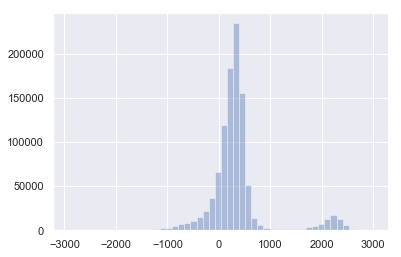

In [6]:
sns.distplot(distances, kde=False)

In [7]:
distances = []
names = []
#for n in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
#for n in [0, 0.4]:
    print(n)
    group = data.loc[data['contamination'] == n].values
    labels = group[:,-1]
    group = group[:,:-1]

    distances.append(pdist(group, lambda u, v: b_metric(u,v, alpha)))
    names.append(n)


archea.fasta


TypeError: ufunc 'loggamma' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [71]:
plt.boxplot(distances, labels=names)
plt.show()

In [75]:
sns.distplot(distances[0],kde=False, color='blue', label='pure')
sns.distplot(distances[1],kde=False, color='darkorange', label='40% contamination')
plt.legend()

In [65]:
d_list = []
std=[]
for i in range(len(distances)):
    d_list.append(distances[i][distances[i] < 100000000].mean())
    std.append(distances[i][distances[i] < 100000000].std()*2)
yerr=np.array(std)
plt.errorbar(names,d_list, yerr=yerr, fmt='o', capsize=10 )
plt.show()

In [9]:
vec = []
for i in range(len(distances)):
    for j in distances[i]:
        #vec.append(np.array([j,names[i].split('_')[2]]))
        vec.append(np.array([j,names[i]]))
dist = pd.DataFrame(vec, columns=['dirichlet', 'contamination'])

dist.to_csv("contamination_close_dirichlet.csv",header=True, index=False)

KeyboardInterrupt: 

In [88]:
print(names)
distances[0].mean()

[]


IndexError: list index out of range

# Speed benchmark

In [43]:
def timing(fun):
    t1 = time()
    fun()
    t2 = time()
    print('time of execution: ', t2 - t1)


In [46]:

def new():
    x = group[1]
    n = np.sum(x)
    alpha_0 = np.sum(alpha)

    log_probability = stirling(n+1)+stirling(alpha_0)-stirling(n+alpha_0)

    log_probability += np.sum(stirling(x+alpha)-stirling(x+1)-stirling(alpha))

    log_probability


In [47]:
def old():
    x =group[1]
    n = np.sum(x)
    alpha_0 = np.sum(alpha)

    log_probability = loggamma(n+1)+loggamma(alpha_0)-loggamma(n+alpha_0)

    for k in range(len(x)):
        log_probability += loggamma(x[k]+alpha[k])-loggamma(x[k]+1)-loggamma(alpha[k])

    log_probability


In [63]:
timing(old)

time of execution:  0.007122993469238281


In [64]:
timing(new)

time of execution:  0.00027298927307128906


In [58]:
def test_old():
    group = data.loc[data['contamination'] == 0].values
    labels = group[:100,-1]
    group = group[:100,:-1]


    d = b_metric(group[0],group[1], alpha)
    distances_old = pdist(group, lambda u, v: b_metric_old(u,v, alpha))
    
def test_new():
    group = data.loc[data['contamination'] == 0].values
    labels = group[:100,-1]
    group = group[:100,:-1]


    d = b_metric(group[0],group[1], alpha)
    distances = pdist(group, lambda u, v: b_metric(u,v, alpha))

In [59]:
timing(test_old)

NameError: name 'z' is not defined

In [69]:
timing(test_new)

time of execution:  1.3831815719604492


In [8]:
names

[0.05, 0.4, 0.15, 0.35, 0.3, 0.25, 0.0, 0.1, 0.2]

In [14]:
distances[0].size

583740

In [25]:
x = data.values[0]
x = x[:-1]
y = data.values[100]
y = y[:-1]
p = b_metric(x,y, alpha)

In [18]:
-np.log((1/(+np.exp(p))))

290.12138017652796

In [19]:
np.exp(p)

9.956678701419853e+125

In [122]:
distances[0][distances[0] < 100000000].mean()

297.76106599273623

NameError: name 'group' is not defined

In [7]:
distances_euclid = []
names = []
#for n in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
for n in [0, 0.4]:
    print(n)
    group = data.loc[data['contamination'] == n].values
    labels = group[:,-1]
    group = group[:,:-1]

    distances_euclid.append(pdist(group))
    names.append(n)

0
0.4


In [53]:
plt.boxplot(distances, labels=names)
plt.show()

In [54]:
sns.distplot(distances[8],kde=False)

In [55]:
d_list = []
std=[]
for i in range(len(distances)):
    d_list.append(distances[i].mean())
    std.append(distances[i].std()*2)
yerr=np.array(std)
plt.errorbar(names,d_list, yerr=yerr, fmt='o', capsize=10 )

<ErrorbarContainer object of 3 artists>

In [42]:
plt.plot(distances[0],distances_euclid[0],'.')
plt.xlabel('logBF')
plt.ylabel('Eucilidian')
plt.show()

In [17]:
sns.distplot(distances_euclid[0],kde=False, color='blue', label='pure')
sns.distplot(distances_euclid[1],kde=False, color='darkorange', label='40% contamination')
plt.legend()

## Alpha parameters tuning

In [9]:
param = [0.01, 0.1, 1, 10, 100]
a_distances=[]
for i in param:
    print(i)
    a_distances.append(pdist(data, lambda u, v: b_metric(u,v, alpha*i)))

0.01
0.1
1
10
100


In [16]:
plt.figure()
for i in range(len(param)):
    plt.subplot(3,2,i+1)
    sns.distplot(a_distances[i],kde=False)